In [1]:
# Import libraries
import pandas as pd
import requests
import gdown
import pyarrow
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
df_train_series = pd.read_parquet('train_series.parquet')
df_train_events = pd.read_csv('train_events.csv')

1. If one series_id have some lines with Nan value, delete these lines 

In [3]:
# Remove rows where 'step' is NaN from the df_train_events DataFrame
df_train_events_cleaned = df_train_events.dropna(subset=['step'])

# Now df_train_events_cleaned contains all the original data minus the rows where 'step' was NaN

# If you want to get the list of series_id that still have full coverage after the removal
fully_coverage_series_ids = df_train_events_cleaned.groupby('series_id').apply(lambda x: x['step'].isnull().sum() == 0)
fully_coverage_series_ids = fully_coverage_series_ids.index[fully_coverage_series_ids].tolist()

len(fully_coverage_series_ids)  
# This will give you the count of series_id without any NaN in 'step'


269

left 269 series_id after deleting Nan value lines

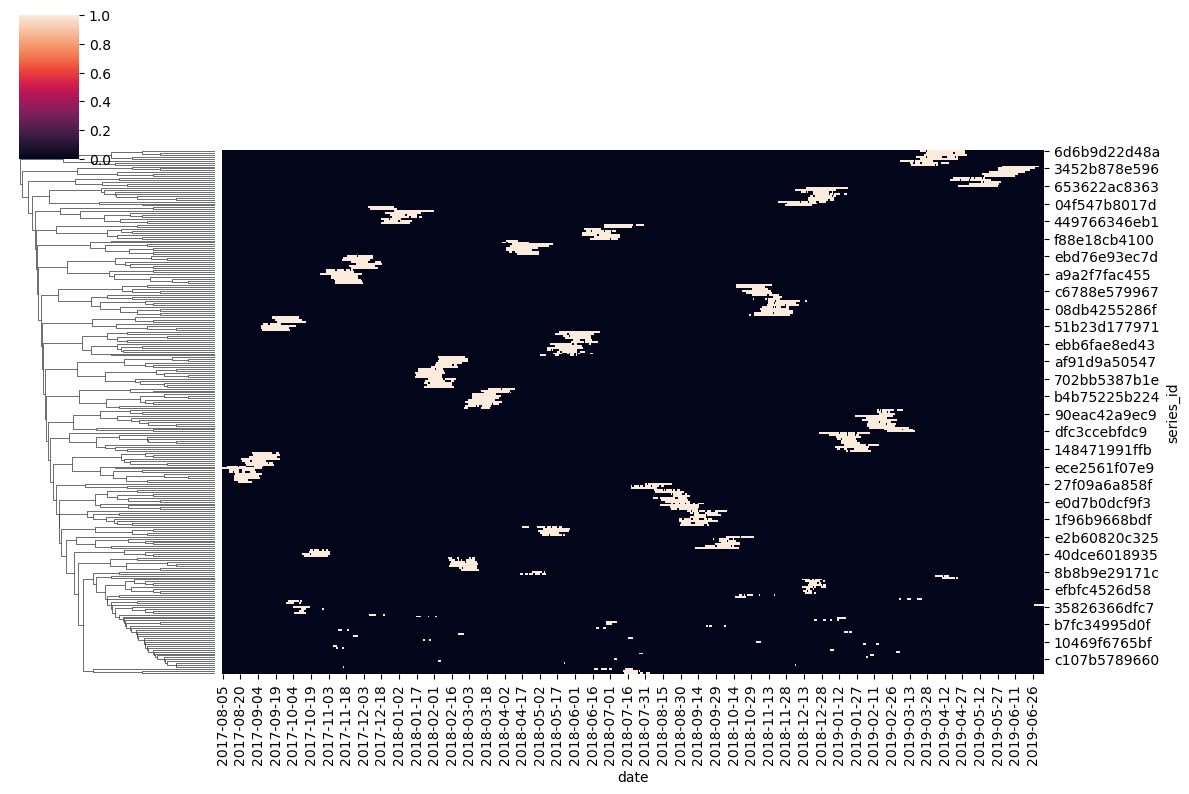

In [4]:
df_train_events['date'] = df_train_events['timestamp'].str.split('T', expand=True)[0]

# Pivot the DataFrame to create df_availability
df_availability = df_train_events.pivot_table(columns='date', index='series_id', values='step', aggfunc='count')

# Fill NA values with 0
df_availability = (~df_availability.isna()).fillna(0).astype('int')

# Plotting the clustered heatmap
sns.clustermap(df_availability, col_cluster=False, figsize=(12, 8))

Analysis:

This is a clustermap that contains some information about the data.

The y-axis represents individual time series clustered based on their data collection similarity.

The x-axis represents the time series data points. And we notice that the collected of data time series is from 2017 to 2019.

Upon examining the clustermap, it is evident that the majority of the series tend to have a duration spanning 20 to 30 days.

And there is some missing data in the time series dataset. The missing data is represented by the white color in the clustermap.

The missing data is not evenly distributed across the time series. Some time series have a lot of missing data, while others have very little.



2. If one series_id have lines with Nan value, delete this series_id, just same as preprocessing.ipynb we did before. And we can get fully_coverage_series_ids==37

In [5]:
# Group the series_id and check the step column of each group for NaN values
fully_coverage_series_ids = df_train_events.groupby('series_id').apply(lambda x: x['step'].isnull().sum() == 0)

# only choose the series_id that have full coverage
fully_coverage_series_ids = fully_coverage_series_ids.index[fully_coverage_series_ids].tolist()

len(fully_coverage_series_ids)

37

In [6]:
def get_train_series(series):
    # Filter the data for the current series
    train_series = df_train_series[df_train_series['series_id'] == series]
    train_events = df_train_events[df_train_events['series_id'] == series]

   # Cleaning and preprocessing
    train_events = train_events.dropna()
    train_events["step"] = train_events["step"].astype("int")
    train_events["awake"] = train_events["event"].replace({"onset": 0, "wakeup": 1})

   # Merge the series and events data
    train = pd.merge(train_series, train_events[['step', 'awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis='rows')

    # The last event is always "wakeup" so we can fill the NaN values with 1
    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")

    return train

Plot the anglez and enmo columns of the processed data using the lineplot function from the seaborn library.

The anglez may represent a change in some angle.

Enmo may be a calculated motion parameter, often used in activity monitoring.

The purpose of plotting these graphs is usually to analyze or demonstrate patterns, trends, or relationships in time-series data. For example, in a sleep monitoring study, these charts can be used to see the relationship between a subject's movement and their wakefulness.

### Anglez for series 08db4255286f

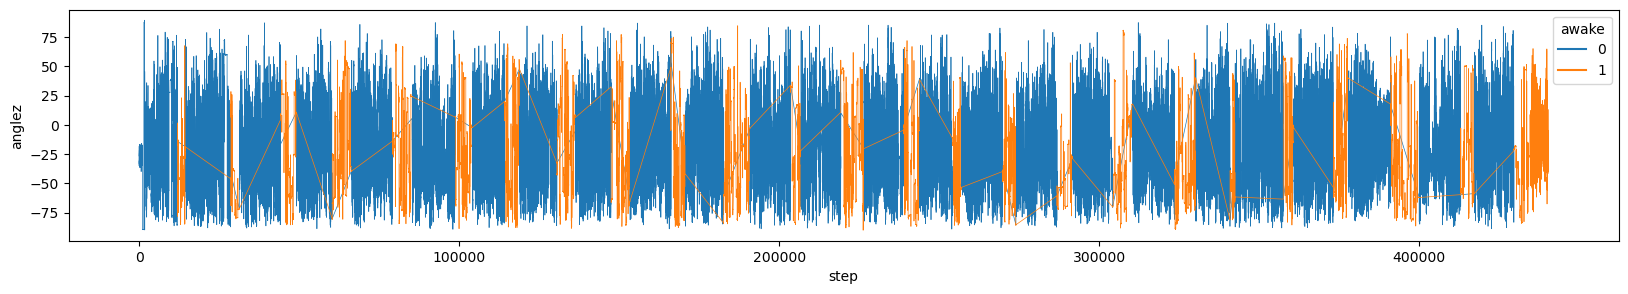

### ENMO for series 08db4255286f

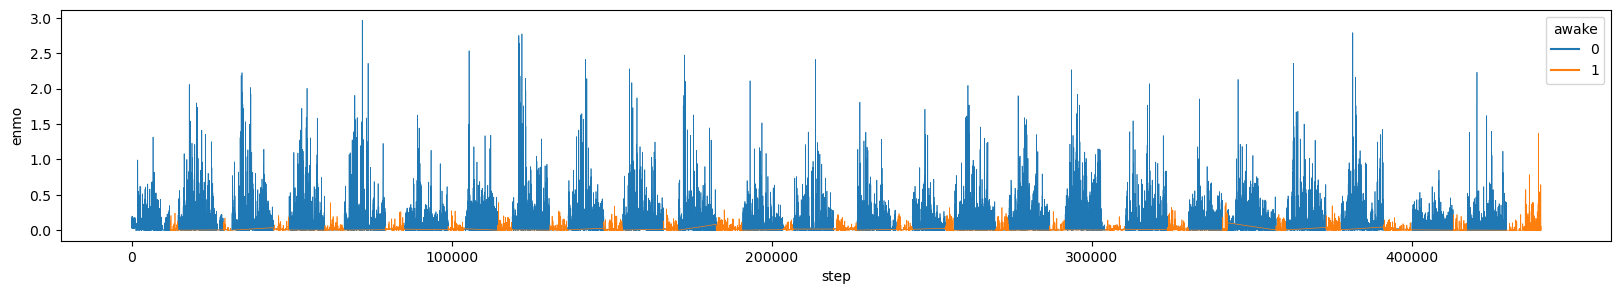

### Anglez for series 0a96f4993bd7

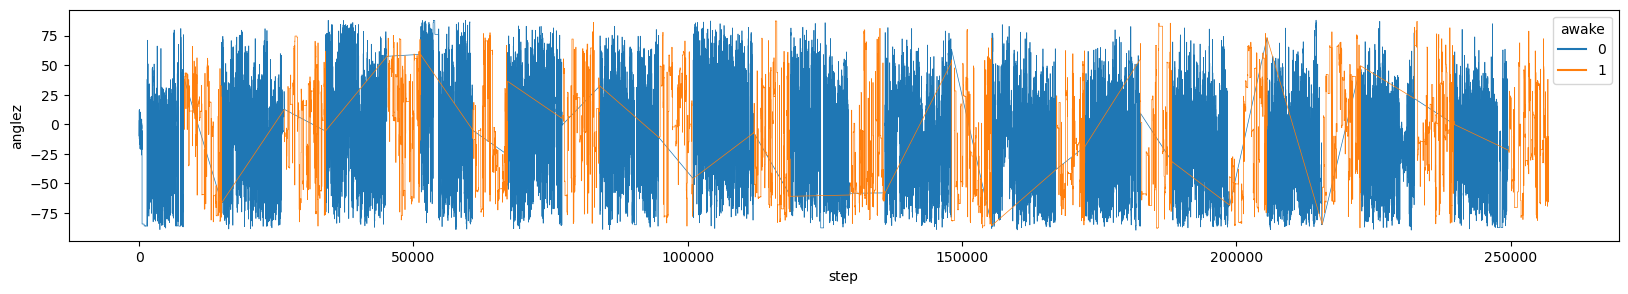

### ENMO for series 0a96f4993bd7

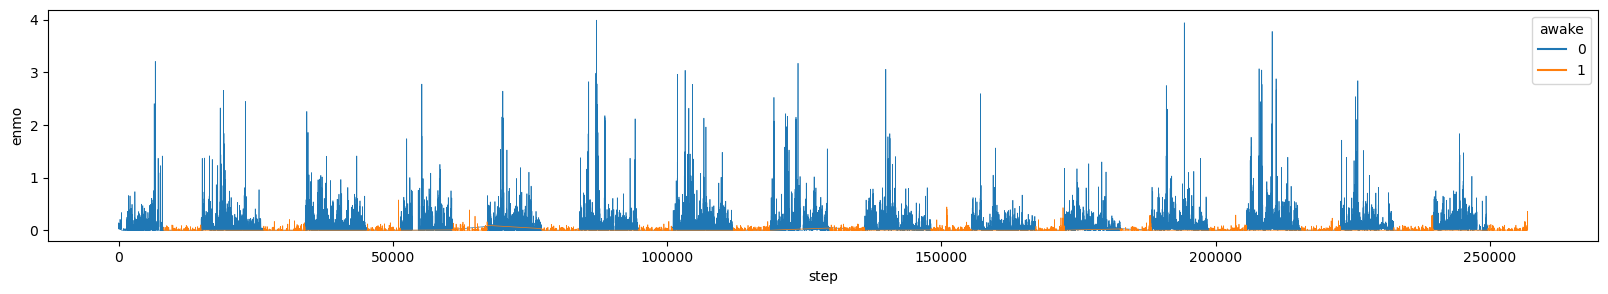

In [7]:
# Container for storing the processed data
smaller_train_data = []

# Loop over the first two series_id entries only
for series_id in fully_coverage_series_ids[:2]:  # Slicing to get the first two
    # Get the series data
    train = get_train_series(series_id)
    smaller_train_data.append(train)
    
    # Visualize 'anglez' for the series
    display(Markdown(f'### Anglez for series {series_id}'))
    plt.figure(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="anglez", hue="awake", linewidth=0.5)
    plt.show()
    
    # Visualize 'enmo' for the series
    display(Markdown(f'### ENMO for series {series_id}'))
    plt.figure(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="enmo", hue="awake", linewidth=0.5)
    plt.show()
    
    # Clear the memory
    del train
    gc.collect()

There are some findings in the plot:
1. Enmo levels decrease during sleep periods—defined as the time between Onset and Wakeup events.
2. For anglez, the intensity appears to differ between sleep and wake times, but not very significant.
3. Interestingly, not all profiles are consistently labeled, and some appear to be repetitive over multiple days.

In [8]:
import pandas as pd
import plotly.express as px

df_train_events['timestamp'] = pd.to_datetime(df_train_events['timestamp'], utc=True)

# create pivot table
pivot = df_train_events.pivot_table(index='series_id', columns='event', values='timestamp', aggfunc=['min', 'max'])
pivot.columns = [f'{level}_{col}_ts' for level, col in pivot.columns] 

# Creating an event summary table
events_summary = df_train_events \
    .groupby('series_id') \
    .agg(count_events=('event', 'count'), count_non_null_events=('step', 'count')) \
    .join(pivot, how='left')

# insert a new column with the percentage of non-null events
events_summary['pct_non_null_events'] = events_summary['count_non_null_events'] / events_summary['count_events']

# sort the DataFrame by the percentage of non-null events
events_summary = events_summary.sort_values(['pct_non_null_events', 'count_non_null_events'], ascending=[False, True])

# make sure three different series
complete_series = events_summary.query('pct_non_null_events == 1.0')
empty_series = events_summary.query('pct_non_null_events == 0.0')
incomplete_series = events_summary.query('(pct_non_null_events > 0.0) & (pct_non_null_events < 1.0)')

summary_evt = {
    'event_coverage': ['Full', 'Partial', 'Missing'],
    'series_count': [complete_series.shape[0], incomplete_series.shape[0], empty_series.shape[0]]
}

agg_data = pd.DataFrame(summary_evt)

fig = px.bar(agg_data, x='event_coverage', y='series_count', 
             title='Number of series with full, partial, and missing event label coverage',
             text='series_count',
             color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_layout(title_x=0.5)
fig.show()


In [9]:
import pandas as pd

df_train_events['timestamp'] = pd.to_datetime(df_train_events['timestamp'], errors='coerce')

df_train_events['hour'] = df_train_events['timestamp'].dt.hour

print(df_train_events.head())


      series_id  night   event     step                 timestamp        date  \
0  038441c925bb      1   onset   4992.0 2018-08-15 02:26:00+00:00  2018-08-14   
1  038441c925bb      1  wakeup  10932.0 2018-08-15 10:41:00+00:00  2018-08-15   
2  038441c925bb      2   onset  20244.0 2018-08-15 23:37:00+00:00  2018-08-15   
3  038441c925bb      2  wakeup  27492.0 2018-08-16 09:41:00+00:00  2018-08-16   
4  038441c925bb      3   onset  39996.0 2018-08-17 03:03:00+00:00  2018-08-16   

   hour  
0   2.0  
1  10.0  
2  23.0  
3   9.0  
4   3.0  


visualize the frequency of onset and wakeup events by hours in a day

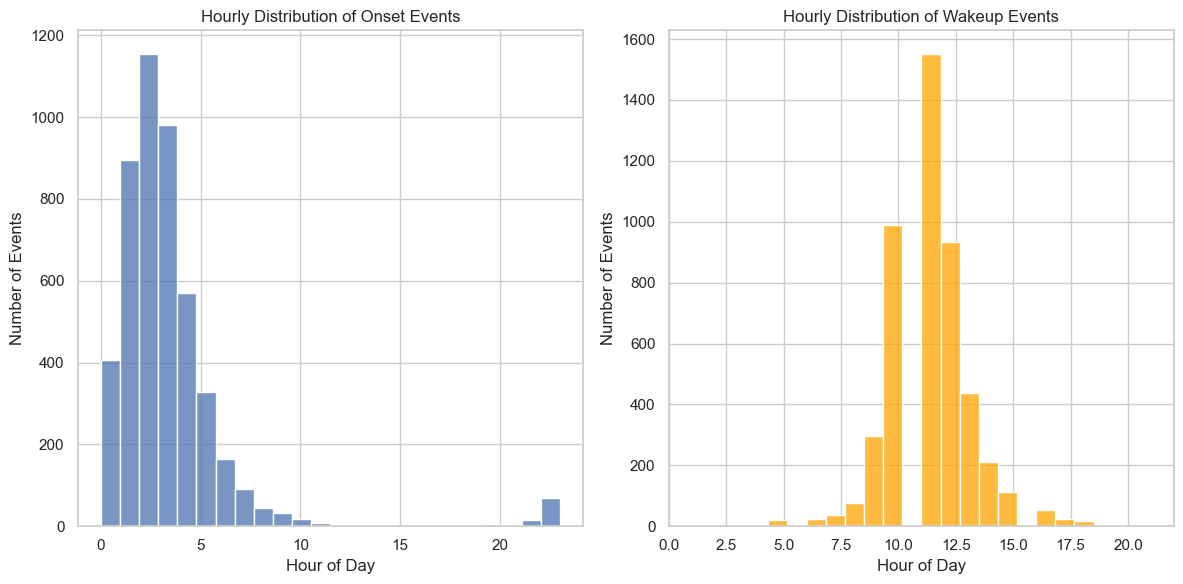

In [10]:
df_onset = df_train_events[df_train_events['event'] == 'onset']
df_wakeup = df_train_events[df_train_events['event'] == 'wakeup']

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

sns.histplot(df_onset['hour'], bins=24, kde=False)
plt.title('Hourly Distribution of Onset Events')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')


plt.subplot(1, 2, 2)

sns.histplot(df_wakeup['hour'], bins=24, kde=False, color='orange')
plt.title('Hourly Distribution of Wakeup Events')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')


plt.tight_layout()
plt.show()

From the charts displayed, it is evident that the majority of individuals whose sleeping series are represented in the training dataset tend to

wake up between 6-8 am;
go to sleep around 8-10 pm.

Such a temporal pattern matches well with general intuition as well as provides a useful baseline for further analyses.

In [11]:
# Aggregate data and calculate counts for each event type in each hour
agg_data = df_train_events[["event", "hour"]].groupby(["event", "hour"]).size().reset_index(name="count")

agg_data["hour"] = agg_data["hour"].astype(int)

# create a sunburst chart
fig = px.sunburst(
    agg_data,
    values='count',              
    path=["event", "hour"],     
    title="Events by hours in a day", 
    color="event",            
    height=500,             
    color_discrete_sequence=px.colors.qualitative.Prism  
)
fig.update_layout(title_x=0.5)
fig.show()


As we can see, the number of onset and wakeup events is quite balanced in the training dataset, which indicates no labelling errors on the series where labels were generated (either fully or parcially).

However, as displayed in the sunburst chart above, the number of wakeup events is slightly higher then the number of onset events (the difference is 3 events, namely). It means the tiny fraction of the training series does have more wakeup events labeled than onset once. Let's locate the training series affected by such a mislabelling.

Since the timestamps in both the series and events data are presented with the local time zone offsets, the real question is whether it makes sense to keep the event time in the local time zones or cast them all to UTC. This section is going to visualize some TZ-related patterns.

In [12]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

ground_truth = pd.read_csv("train_events.csv")

# get event counts in UTC
df = ground_truth.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"],utc=True)
df["hour"] = df["timestamp"].dt.hour

# filter for mornings and afternoons
df_morning   = df.loc[df["hour"] <= 12].copy()
df_afternoon = df.loc[df["hour"]  > 12].copy()

utc_stat = {
    "label": "UTC",
    "morning_wakeups": df_morning.loc[df_morning["event"] == "wakeup"].shape[0],
    "morning_onsets": df_morning.loc[df_morning["event"] == "onset"].shape[0],
    "afternoon_onsets": df_afternoon.loc[df_afternoon["event"] == "onset"].shape[0],
    "afternoon_wakeups": df_afternoon.loc[df_afternoon["event"] == "wakeup"].shape[0]
}

# get event counts in the local time zone time
df = ground_truth.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert(None)

df["hour"] = df["timestamp"].dt.hour
# filter for mornings and afternoons
df_morning   = df.loc[df["hour"] <= 12].copy()
df_afternoon = df.loc[df["hour"]  > 12].copy()

local_tz_stat = {
    "label": "Local time",
    "morning_wakeups": df_morning.loc[df_morning["event"] == "wakeup"].shape[0],
    "morning_onsets": df_morning.loc[df_morning["event"] == "onset"].shape[0],
    "afternoon_onsets": df_afternoon.loc[df_afternoon["event"] == "onset"].shape[0],
    "afternoon_wakeups": df_afternoon.loc[df_afternoon["event"] == "wakeup"].shape[0]
}

data = [utc_stat, local_tz_stat]
df_stat = pd.DataFrame.from_dict(data)

fig = make_subplots(rows=2, cols=2, subplot_titles=('Morning Wakeups: UTC vs. Local time',
                                                    'Morning Onsets: UTC vs. Local time',
                                                    'Afternoon Onsets: UTC vs. Local time',
                                                    'Afternoon Wakeups: UTC vs. Local time'
                                                   ))

fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['morning_wakeups']), row=1, col=1)
fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['morning_onsets']), row=1, col=2)
fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['afternoon_onsets']), row=2, col=1)
fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['afternoon_wakeups']), row=2, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=600,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)

# Update font in the titles: Apparently subplot titles are annotations 
fig.update_annotations(font_size=12)

# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()

We can see that operating the events / series timestamps in the local time makes more sense from the logical standpoint as the number of wakeup/onset events in the morning and afternoon looks more intuitive.

In [13]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [14]:
# Distribution of onset/wakeup events in 15-minute intervals
mn_train_events = pd.read_csv('train_events.csv')
mn_train_events = mn_train_events.loc[~mn_train_events['timestamp'].isna()] # drop Nan values

df_onset_mn = mn_train_events[mn_train_events['event'] == 'onset']
df_wakeup_mn = mn_train_events[mn_train_events['event'] == 'wakeup']

min15_onset = df_onset_mn['timestamp'].str[-10:-8].astype('int32')%15 # minute of event, in 15 min blocks
min15_wakeup = df_wakeup_mn['timestamp'].str[-10:-8].astype('int32')%15 # minute of event, in 15 min blocks

frame1 = {'interval': min15_onset.index,
         'onset_minute': min15_onset}
 
# Creating DataFrame by passing Dictionary
agg_data_onsets = pd.DataFrame(frame1)

frame2 = {'interval': min15_wakeup.index,
         'wakeup_minute': min15_wakeup}
 
# Creating DataFrame by passing Dictionary
agg_data_wakeups = pd.DataFrame(frame2)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Distr. of Onset Events in 15-min intervals',
                                                    'Distr. of Wakeup Events in 15-min intervals',
                                                   ))

fig.add_trace(go.Histogram(x=agg_data_onsets['onset_minute'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=agg_data_wakeups['wakeup_minute'].dropna(), nbinsx=24), row=1, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=700,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)

fig.update_annotations(font_size=12)

# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()

In [15]:
# Try using a similar scoring tool to identify clusters of series. 
# There are not many events in each series, so comparing the number of events in 0, 3, 7, and 11 to the number of other events provides a measure of the effect of a certain amount of signal on the noise.
def is_in_frequent_event_minute_slot(x):
    value = 0
    if x in [0,3,7,11]:
        value = 1
    return value

def is_in_other_event_minute_slot(x):
    value = 0
    if x not in [0,3,7,11]:
        value = 1
    return value

df_onset_mn['timestamp'] = pd.to_datetime(df_onset_mn['timestamp'], utc=True).dt.tz_convert(None)
df_onset_mn['hour'] = df_onset_mn["timestamp"].dt.hour
df_onset_mn['minute'] = df_onset_mn["timestamp"].dt.minute
df_onset_mn['15min'] = df_onset_mn['minute'] % 15

df_onset_mn['in_0_3_7_11_slot'] = df_onset_mn['15min'].apply(lambda x: is_in_frequent_event_minute_slot(x))
df_onset_mn['in_other_slot'] = df_onset_mn['15min'].apply(lambda x: is_in_other_event_minute_slot(x))

df_series_agg = df_onset_mn.groupby(['series_id'])[['in_0_3_7_11_slot', 'in_other_slot']].sum().reset_index()

fig = px.scatter(df_series_agg, x="in_0_3_7_11_slot", y="in_other_slot",
                 size='in_0_3_7_11_slot', 
                 title='Onset events in minute buckets: [0,3,7,11] vs. others',
                 color_discrete_sequence=px.colors.qualitative.Prism,
                 hover_data=['series_id'])
fig.show()

In [16]:
df_series_agg['ratio_0_3_7_11'] = df_series_agg['in_0_3_7_11_slot'] / (df_series_agg['in_0_3_7_11_slot'] + df_series_agg['in_other_slot'])
df_series_agg['ratio_other'] = 1 - df_series_agg['ratio_0_3_7_11']

fig = make_subplots(rows=1, cols=2, subplot_titles=('<b>Distr. of Onsets ratio in [0,3,7,11] minute bucket</b>',
                                                    '<b>Distr. of Onsets ratio in other minute bucket</b>',
                                                   ))

fig.add_trace(go.Histogram(x=df_series_agg['ratio_0_3_7_11'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=df_series_agg['ratio_other'].dropna(), nbinsx=24), row=1, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=800,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)

# Update font in the titles: Apparently subplot titles are annotations 
fig.update_annotations(font_size=12)
# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()

In [17]:
# wakeup
df_wakeup_mn['timestamp'] = pd.to_datetime(df_wakeup_mn['timestamp'], utc=True).dt.tz_convert(None)
df_wakeup_mn['hour'] = df_wakeup_mn["timestamp"].dt.hour
df_wakeup_mn['minute'] = df_wakeup_mn["timestamp"].dt.minute
df_wakeup_mn['15min'] = df_wakeup_mn['minute'] % 15

df_wakeup_mn['in_0_3_7_11_slot'] = df_wakeup_mn['15min'].apply(lambda x: is_in_frequent_event_minute_slot(x))
df_wakeup_mn['in_other_slot'] = df_wakeup_mn['15min'].apply(lambda x: is_in_other_event_minute_slot(x))

df_series_agg = df_wakeup_mn.groupby(['series_id'])[['in_0_3_7_11_slot', 'in_other_slot']].sum().reset_index()

fig = px.scatter(df_series_agg, x="in_0_3_7_11_slot", y="in_other_slot",
                 size='in_0_3_7_11_slot', 
                 title='Wakeup events in minute buckets: [0,3,7,11] vs. others',
                 color_discrete_sequence=px.colors.qualitative.Prism,
                 hover_data=['series_id'])
fig.show()